Loading images for class: nowildfire
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 477ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step
16/16 ━━━━━━━━━━━━━

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:06:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9663


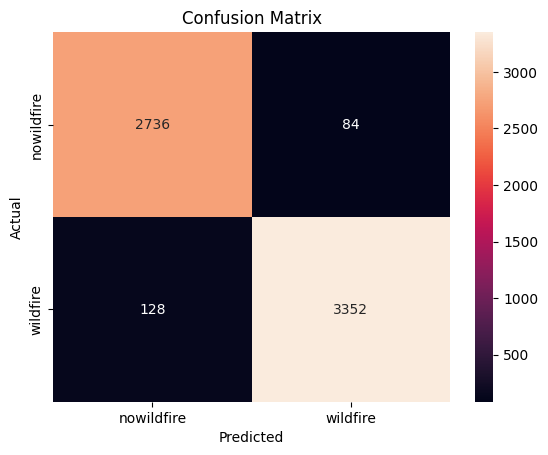

In [7]:
import numpy as np
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import xgboost as xgb

# Parameters
SIZE = 224
BATCH_SIZE = 500

# Function to apply CLAHE for contrast enhancement
def enhance_contrast(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

# Generator to load images batch by batch
def image_generator(folder, batch_size):
    class_folders = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    images, labels = [], []

    for class_folder in class_folders:
        class_path = os.path.join(folder, class_folder)
        print(f"Loading images for class: {class_folder}")

        for img_path in glob.glob(os.path.join(class_path, "*.jpg")):
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (SIZE, SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = enhance_contrast(img)
                images.append(preprocess_input(img))
                labels.append(class_folder)

                # Yield batch when full
                if len(images) == batch_size:
                    yield np.array(images, dtype='float16'), np.array(labels)
                    images, labels = [], []

            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

    # Yield remaining images
    if images:
        yield np.array(images, dtype='float16'), np.array(labels)

# Load MobileNetV2 for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

# Extract features batch by batch
def extract_features(generator):
    features, all_labels = [], []
    for images, labels in generator:
        batch_features = model.predict(images, batch_size=32, verbose=1)
        features.append(batch_features)
        all_labels.extend(labels)
    return np.vstack(features), np.array(all_labels)

# Process training and testing datasets in batches
train_gen = image_generator("archive (2)\\train", BATCH_SIZE)
test_gen = image_generator("archive (2)\\test", BATCH_SIZE)

x_train, train_labels = extract_features(train_gen)
x_test, test_labels = extract_features(test_gen)

# Encode labels
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)

# Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    verbosity=1,
    use_label_encoder=False
)
xgb_model.fit(x_train, train_labels_encoded)

# Make predictions
predictions = xgb_model.predict(x_test)
accuracy = accuracy_score(test_labels_encoded, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels_encoded, predictions)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


MODEL PERFORMANCE EVALUATION
XGBoost Model Accuracy: 0.9663
Precision: 0.9665
Recall: 0.9663
F1 Score: 0.9664

SUMMARY TABLE
Model                     Accuracy   Precision  Recall     F1 Score  
-----------------------------------------------------------------
XGBoost Model             0.9663     0.9665     0.9663     0.9664    


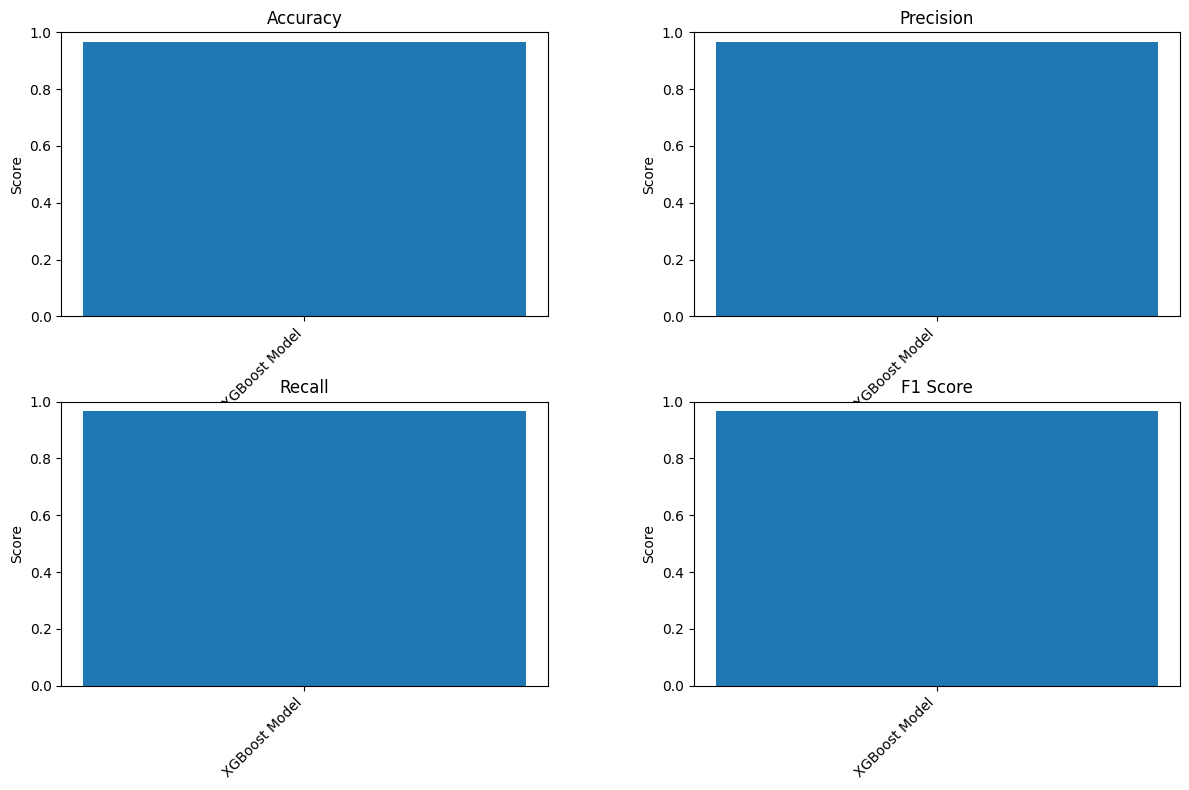

{'XGBoost Model': {'accuracy': 0.9663492063492064,
  'precision': 0.9664906049307816,
  'recall': 0.9663492063492064,
  'f1': 0.966372408040618}}

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate model performance with detailed metrics
def evaluate_model_performance(model, x_test, y_test, class_names):
    print("=" * 50)
    print("MODEL PERFORMANCE EVALUATION")
    print("=" * 50)
    
    results = {}
    
    # Make predictions
    y_pred = model.predict(x_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"XGBoost Model Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    results['XGBoost Model'] = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Create summary table
    print("\n" + "=" * 50)
    print("SUMMARY TABLE")
    print("=" * 50)
    print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
    print("-" * 65)
    
    for model_name, metrics in results.items():
        print(f"{model_name:<25} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f}")
    
    # Visualize results
    plt.figure(figsize=(12, 8))
    
    # Plot accuracy comparison
    plt.subplot(2, 2, 1)
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]
    plt.bar(models, accuracies)
    plt.title('Accuracy')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Plot precision comparison
    plt.subplot(2, 2, 2)
    precisions = [results[model]['precision'] for model in models]
    plt.bar(models, precisions)
    plt.title('Precision')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Plot recall comparison
    plt.subplot(2, 2, 3)
    recalls = [results[model]['recall'] for model in models]
    plt.bar(models, recalls)
    plt.title('Recall')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Plot F1 comparison
    plt.subplot(2, 2, 4)
    f1s = [results[model]['f1'] for model in models]
    plt.bar(models, f1s)
    plt.title('F1 Score')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    
    return results

# Call the detailed evaluation function
evaluate_model_performance(xgb_model, x_test, test_labels_encoded, le.classes_)


Image 1:
True Class: nowildfire
Predicted Class: nowildfire
Confidence: 99.22%

Image 2:
True Class: wildfire
Predicted Class: wildfire
Confidence: 98.21%

Image 3:
True Class: nowildfire
Predicted Class: nowildfire
Confidence: 99.87%

Image 4:
True Class: wildfire
Predicted Class: wildfire
Confidence: 89.76%

Image 5:
True Class: wildfire
Predicted Class: wildfire
Confidence: 99.76%


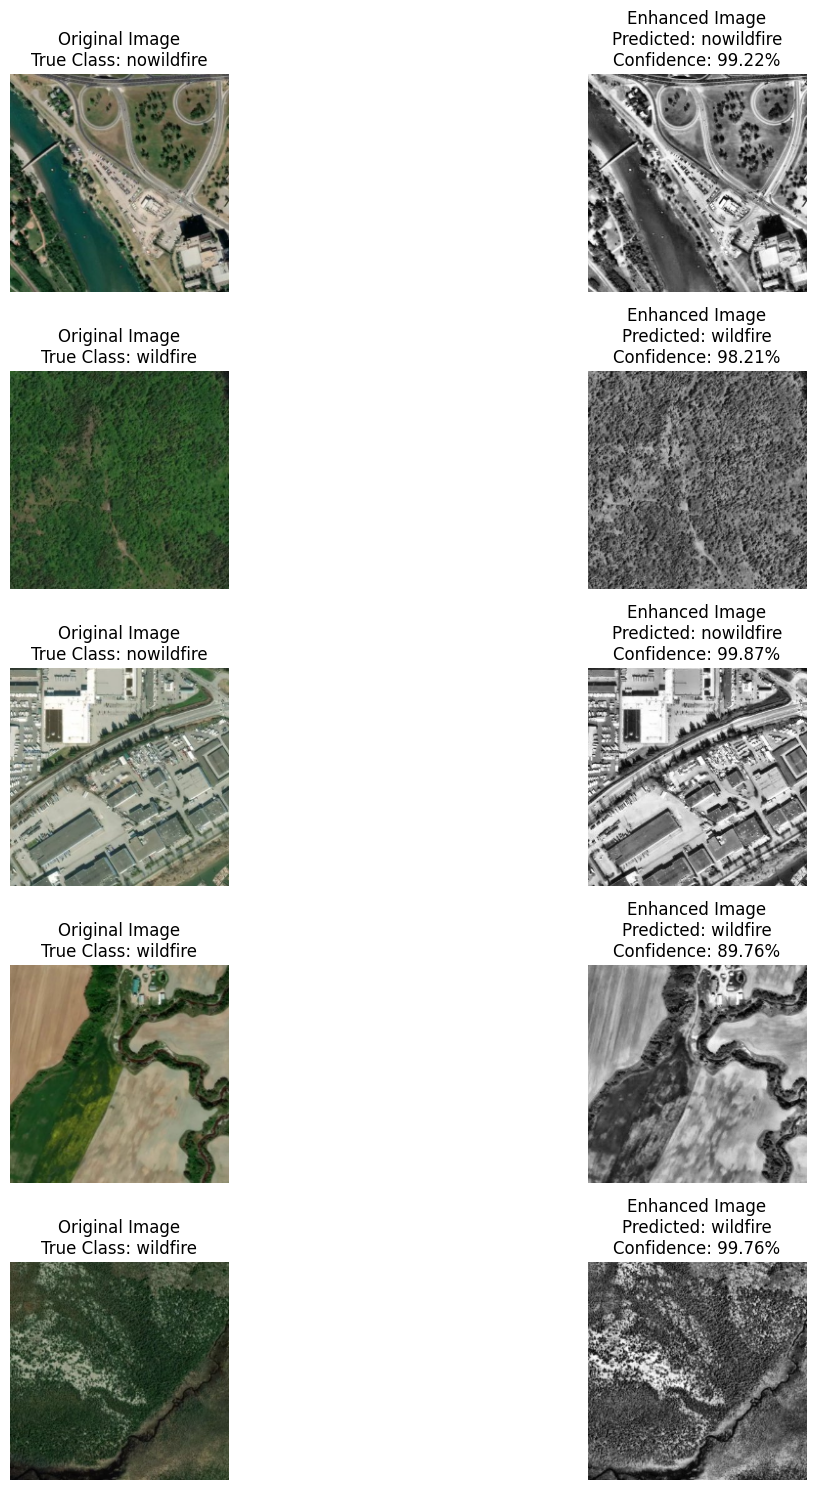

In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def predict_random_images(validation_folder, model, xgb_model, label_encoder, num_images=5):
    """
    Randomly select images from validation folder, predict their classes and display results
    """
    # Get all image paths
    image_paths = []
    for class_folder in os.listdir(validation_folder):
        folder_path = os.path.join(validation_folder, class_folder)
        if os.path.isdir(folder_path):
            image_paths.extend([
                (os.path.join(folder_path, img), class_folder)
                for img in os.listdir(folder_path)
                if img.endswith(('.jpg', '.jpeg', '.png'))
            ])

    # Randomly select images
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    # Create figure
    fig = plt.figure(figsize=(15, 3*num_images))
    
    for idx, (img_path, true_class) in enumerate(selected_images, 1):
        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img_enhanced = enhance_contrast(img)
        img_preprocessed = preprocess_input(img_enhanced)
        
        # Extract features and predict
        features = model.predict(np.expand_dims(img_preprocessed, axis=0), verbose=0)
        prediction = xgb_model.predict(features)
        predicted_class = label_encoder.inverse_transform(prediction)[0]
        
        # Calculate confidence scores
        probabilities = xgb_model.predict_proba(features)[0]
        confidence = np.max(probabilities) * 100
        
        # Display results
        plt.subplot(num_images, 2, 2*idx-1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Original Image\nTrue Class: {true_class}')
        
        plt.subplot(num_images, 2, 2*idx)
        plt.imshow(img_enhanced)
        plt.axis('off')
        plt.title(f'Enhanced Image\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%')
        
        print(f"\nImage {idx}:")
        print(f"True Class: {true_class}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")
    
    plt.tight_layout()
    plt.show()

validation_folder = "archive (2)\\valid" 
predict_random_images(validation_folder, model, xgb_model, le)

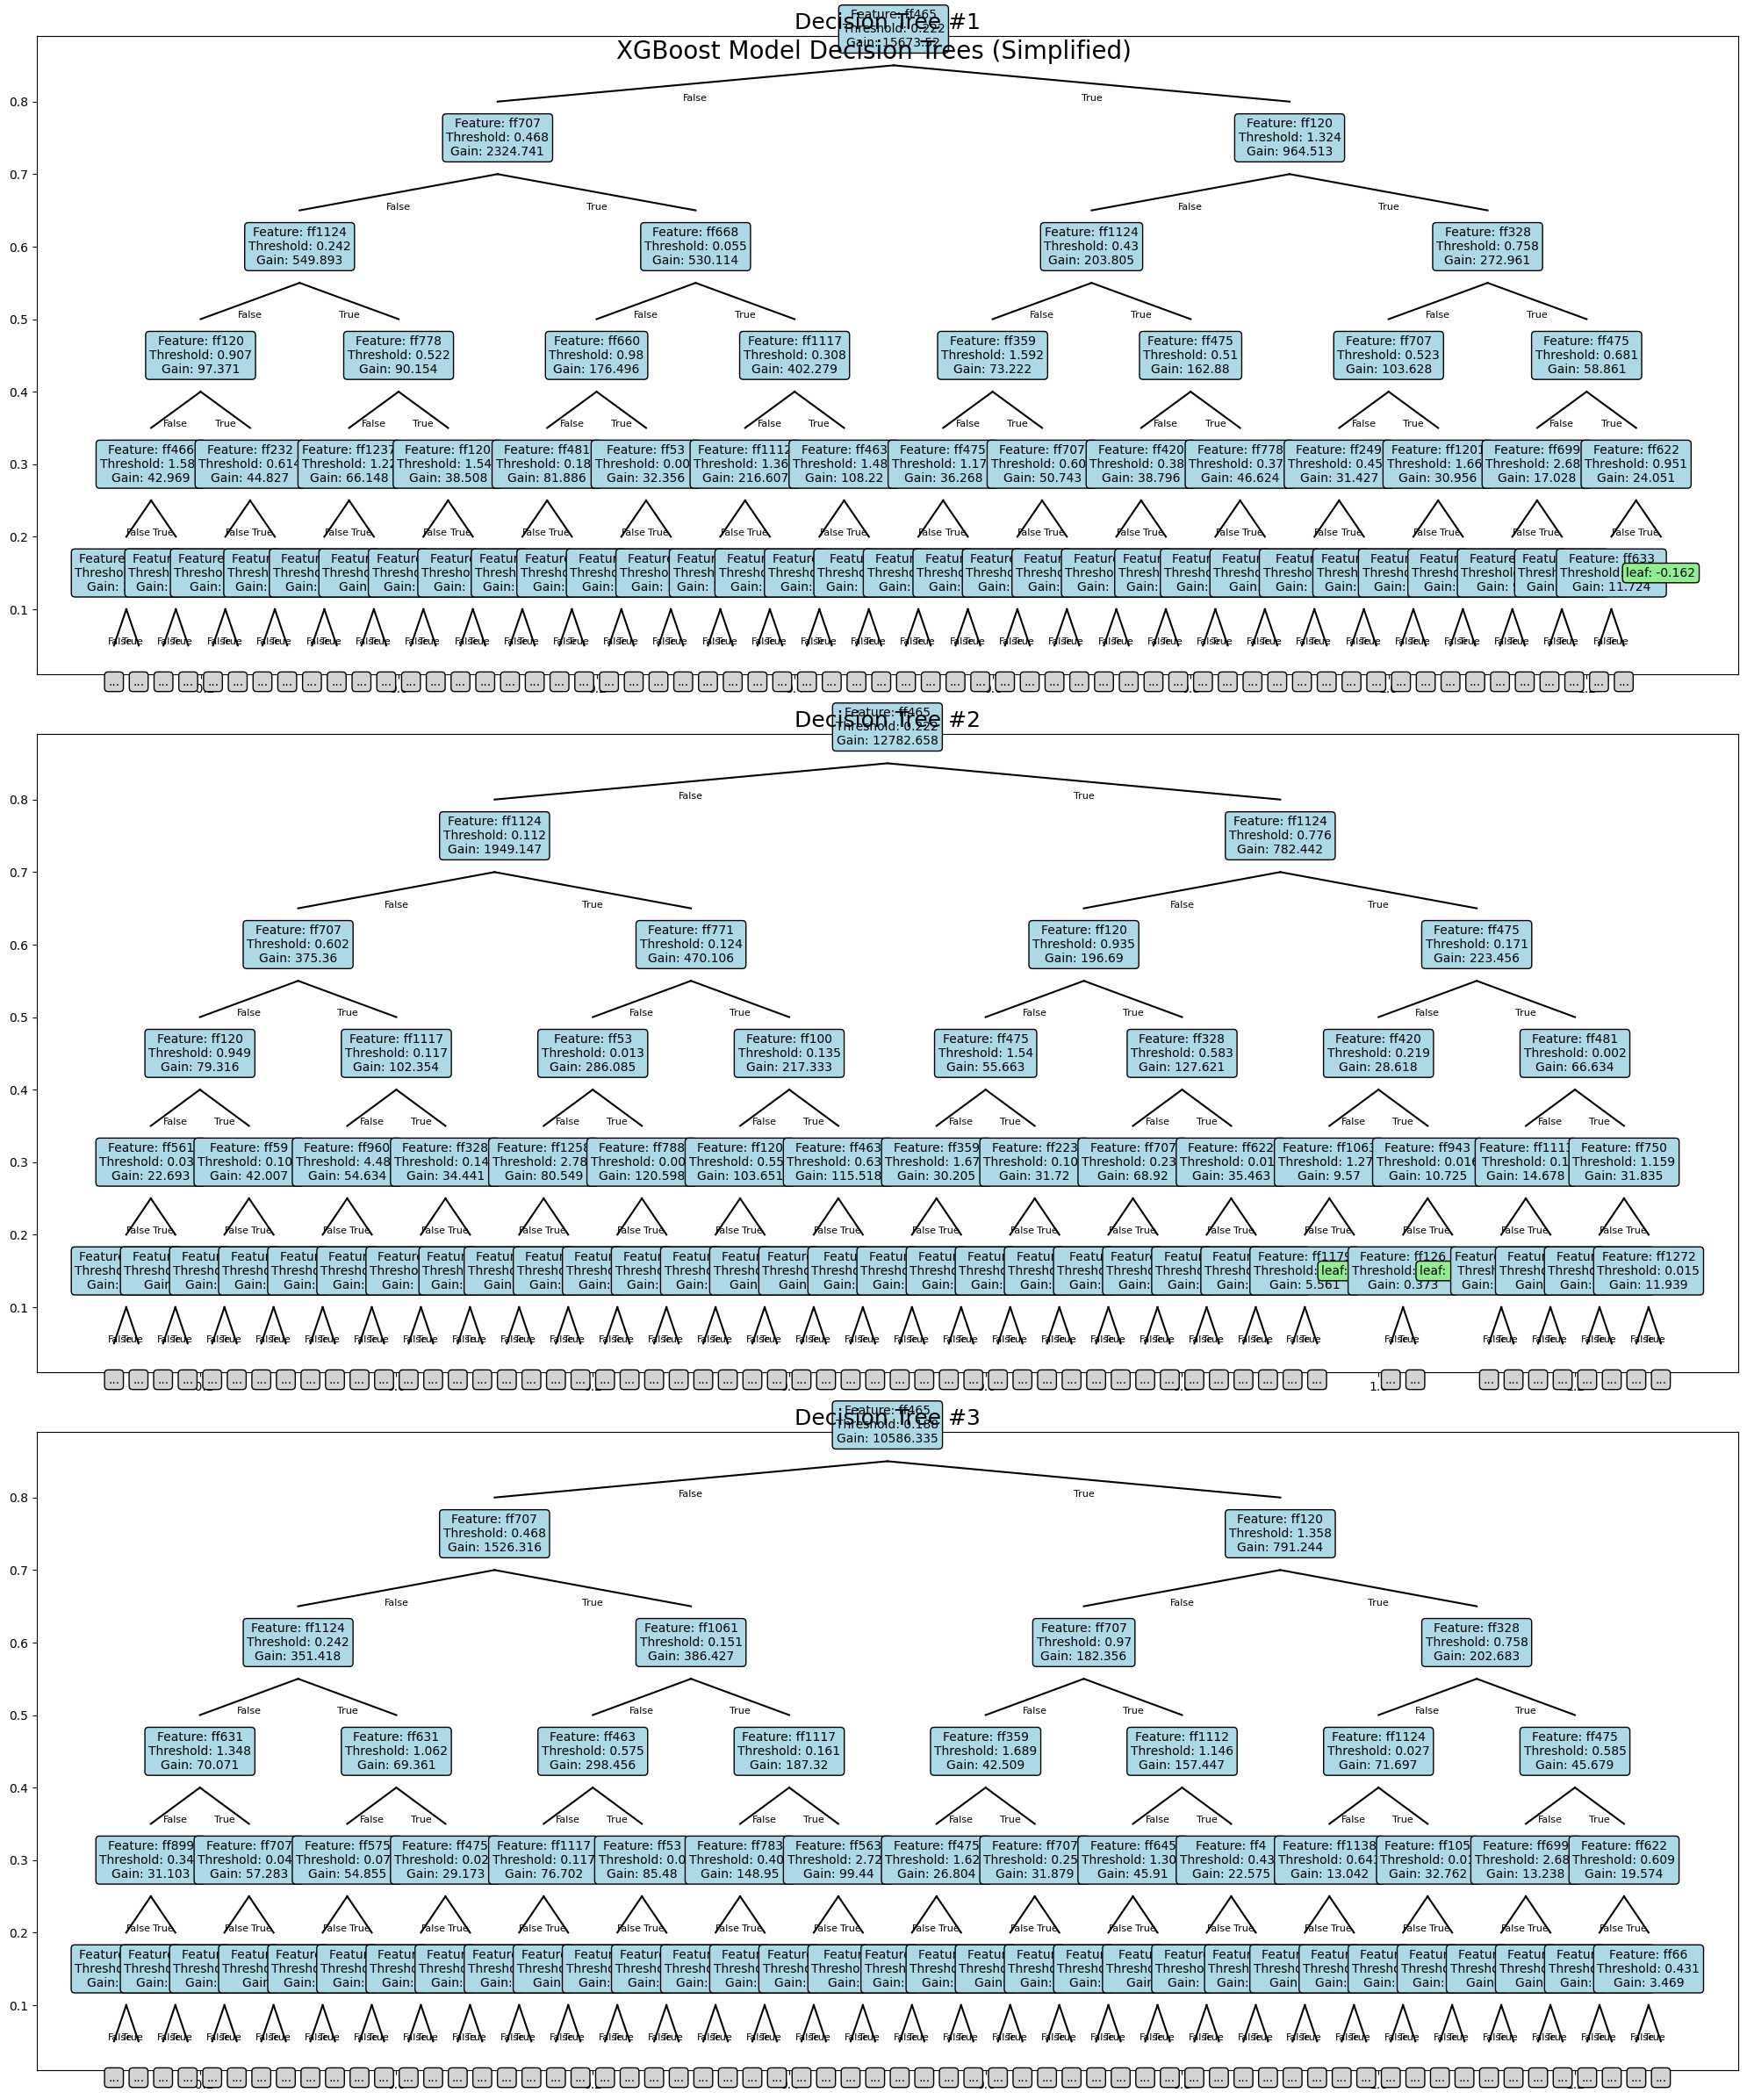

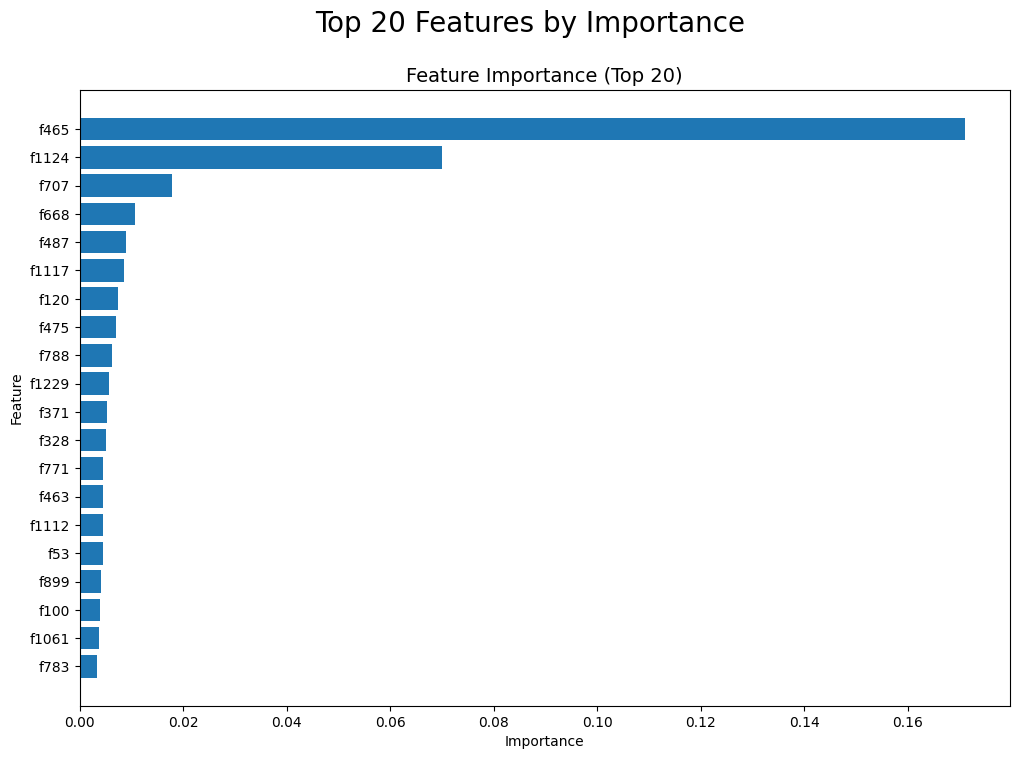

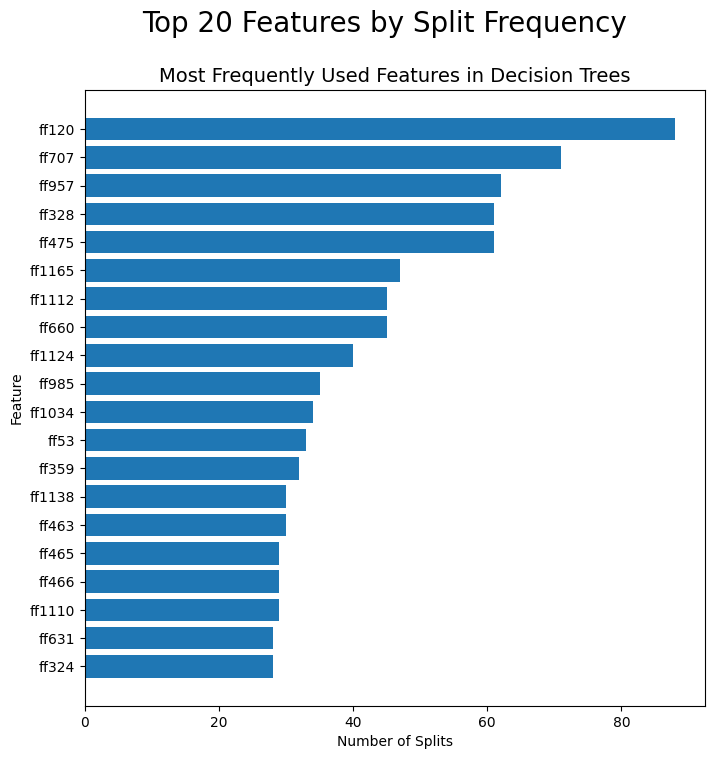

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pylab import rcParams
import pandas as pd
import os

# Set figure size for better visualization
rcParams['figure.figsize'] = 20, 12

def plot_tree_without_graphviz(model, num_trees=3):
    """
    Plot decision trees from XGBoost model
    
    Parameters:
    -----------
    model : XGBoost model
        The trained XGBoost model
    num_trees : int, optional
        Number of trees to plot
    """
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(num_trees, 1, figsize=(20, num_trees * 8))
    
    # If only one tree is requested, make axes a list
    if num_trees == 1:
        axes = [axes]
    
    # Get the booster from the model
    if isinstance(model, xgb.XGBClassifier):
        booster = model.get_booster()
    else:
        booster = model
    
    # Get the tree dump
    trees = booster.get_dump(dump_format='json', with_stats=True)
    
    # Plot each tree as a simple structure
    for i in range(min(num_trees, len(trees))):
        tree_dict = eval(trees[i].replace('null', 'None'))
        ax = axes[i]
        
        # Create a simplified tree representation
        plot_simplified_tree(tree_dict, ax)
        ax.set_title(f'Decision Tree #{i+1}', fontsize=18)
    
    plt.tight_layout()
    return fig

def plot_simplified_tree(tree_dict, ax, x=0.5, y=0.9, width=0.8, depth=0, max_depth=5):
    """Plot a simplified version of the tree using matplotlib"""
    if depth > max_depth:
        ax.text(x, y, "...", ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.3", fc='lightgrey'))
        return
    
    # Current node
    if 'leaf' in tree_dict:
        # Leaf node
        leaf_value = round(tree_dict['leaf'], 3)
        box_props = dict(boxstyle="round,pad=0.3", fc='lightgreen')
        ax.text(x, y, f"leaf: {leaf_value}", ha='center', va='center', 
                bbox=box_props, fontsize=10)
    else:
        # Decision node
        feature = f"f{tree_dict['split']}"
        threshold = round(tree_dict['split_condition'], 3)
        gain = round(tree_dict['gain'], 3) if 'gain' in tree_dict else 'N/A'
        
        node_text = f"Feature: {feature}\nThreshold: {threshold}\nGain: {gain}"
        box_props = dict(boxstyle="round,pad=0.3", fc='lightblue')
        ax.text(x, y, node_text, ha='center', va='center', 
                bbox=box_props, fontsize=10)
        
        # Calculate positions for children
        next_y = y - 0.15
        width_reduction = 0.5  # Reduce width as we go deeper
        new_width = width * width_reduction
        
        # Left child (False branch)
        if 'children' in tree_dict and len(tree_dict['children']) > 0:
            left_child = tree_dict['children'][0]
            left_x = x - width/2
            
            # Draw line to left child
            ax.plot([x, left_x], [y-0.05, next_y+0.05], 'k-')
            ax.text((x + left_x)/2, (y + next_y)/2 - 0.02, "False", ha='center', va='center', fontsize=8)
            
            # Recursive call for left child
            plot_simplified_tree(left_child, ax, left_x, next_y, new_width, depth+1, max_depth)
        
        # Right child (True branch)
        if 'children' in tree_dict and len(tree_dict['children']) > 1:
            right_child = tree_dict['children'][1]
            right_x = x + width/2
            
            # Draw line to right child
            ax.plot([x, right_x], [y-0.05, next_y+0.05], 'k-')
            ax.text((x + right_x)/2, (y + next_y)/2 - 0.02, "True", ha='center', va='center', fontsize=8)
            
            # Recursive call for right child
            plot_simplified_tree(right_child, ax, right_x, next_y, new_width, depth+1, max_depth)

def plot_feature_importance(model, top_n=20):
    """
    Plot feature importance from an XGBoost model
    
    Parameters:
    -----------
    model : XGBoost model
        The trained XGBoost model
    top_n : int, optional
        Number of top features to display
    """
    # Get feature importance
    importance = model.feature_importances_
    
    # Create feature names based on index
    feature_names = [f'f{i}' for i in range(len(importance))]
    
    # Create DataFrame for easier sorting and plotting
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    
    # Select top N features
    feat_imp = feat_imp.head(top_n)
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(np.arange(len(feat_imp)), feat_imp['Importance'].values, align='center')
    plt.yticks(np.arange(len(feat_imp)), feat_imp['Feature'].values)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance (Top 20)', fontsize=14)
    plt.gca().invert_yaxis()  # Highest importance at the top
    
    return plt.gcf()

def get_tree_split_counts(model, top_n=10):
    """
    Get and plot the most commonly used features in splits across all trees
    
    Parameters:
    -----------
    model : XGBoost model
        The trained XGBoost model
    top_n : int, optional
        Number of top features to display
    """
    # Get the booster
    if isinstance(model, xgb.XGBClassifier):
        booster = model.get_booster()
    else:
        booster = model
    
    # Get the tree dump
    trees = booster.get_dump(dump_format='json', with_stats=True)
    
    # Function to extract all split features from a tree
    def extract_split_features(tree_dict):
        features = []
        
        if isinstance(tree_dict, str):
            tree_dict = eval(tree_dict.replace('null', 'None'))
        
        if 'split' in tree_dict:
            features.append(tree_dict['split'])
            
            if 'children' in tree_dict:
                for child in tree_dict['children']:
                    features.extend(extract_split_features(child))
        
        return features
    
    # Extract all features used in splits across all trees
    all_features = []
    for tree in trees:
        tree_features = extract_split_features(tree)
        all_features.extend(tree_features)
    
    # Count feature occurrences
    feature_counts = {}
    for feature in all_features:
        if feature in feature_counts:
            feature_counts[feature] += 1
        else:
            feature_counts[feature] = 1
    
    # Convert to DataFrame and sort
    feature_df = pd.DataFrame({
        'Feature': [f'f{f}' for f in feature_counts.keys()],
        'Split Count': list(feature_counts.values())
    }).sort_values(by='Split Count', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.barh(np.arange(len(feature_df)), feature_df['Split Count'].values, align='center')
    plt.yticks(np.arange(len(feature_df)), feature_df['Feature'].values)
    plt.xlabel('Number of Splits')
    plt.ylabel('Feature')
    plt.title('Most Frequently Used Features in Decision Trees', fontsize=14)
    plt.gca().invert_yaxis()
    
    return plt.gcf()

# Example usage with your model
# Create a simplified visualization of 3 trees from the model
tree_fig = plot_tree_without_graphviz(xgb_model, num_trees=3)
tree_fig.suptitle('XGBoost Model Decision Trees (Simplified)', fontsize=20)

# Plot feature importance
importance_fig = plot_feature_importance(xgb_model, top_n=20)
importance_fig.suptitle('Top 20 Features by Importance', fontsize=20)

# Plot most frequently used features in splits
split_fig = get_tree_split_counts(xgb_model, top_n=20)
split_fig.suptitle('Top 20 Features by Split Frequency', fontsize=20)

plt.show()